In [1]:
from my_packages import *
from appgeopy import *
from pca_imputation import *

In [2]:
def run_pca_imputation_workflow(data, time_col=None, value_col=None):
    """Execute PCA imputation workflow with parameter optimization and validation.
    
    Args:
        data: pandas Series with datetime index or DataFrame
        time_col: column name for time if data is DataFrame
        value_col: column name for value if data is DataFrame
        
    Returns:
        dict: Results containing imputation, parameters, and validation metrics
    """
    # Validate data size and determine appropriate parameters
    data_length = len(data)
    
    # Calculate appropriate embedding dimensions based on data size
    # Ensure embedding dimension doesn't exceed 1/3 of data length
    max_embedding = max(2, data_length // 3)
    
    # Generate embedding dimensions from 2 to max_embedding (capped at 12)
    embedding_dims = list(range(2, min(max_embedding + 1, 13), 2))
    
    # Components must be less than embedding dimensions
    # n_components_list = [min(dim-1, 3) for dim in embedding_dims]
    n_components_list = [max(2, min(dim-1, 3)) for dim in embedding_dims]
    n_components_list = list(set(n_components_list))  # Remove duplicates
    
    # Step 1: Parameter Optimization with safeguards
    try:
        param_results = parameter_grid_search(
            data=data,
            embedding_dims=embedding_dims,
            n_components_list=n_components_list,
            mask_ratio=min(0.1, 0.5 * (1 - data.isna().mean())),  # Adaptive masking
            random_seed=42,
            time_col=time_col,
            value_col=value_col
        )
        
        # Get optimal parameters
        best_params = param_results.loc[param_results['rmse'].idxmin()]
        best_embedding_dim = int(best_params['embedding_dim'])
        best_n_components = int(best_params['n_components'])
    except Exception as e:
        # Fallback to minimal parameters if grid search fails
        best_embedding_dim = 3
        best_n_components = 2
    
    # Step 2: PCA Imputation with Optimal Parameters
    results = impute_time_series(
        data=data,
        embedding_dim=best_embedding_dim,
        n_components=best_n_components,
        time_delay=1,
        time_col=time_col,
        value_col=value_col
    )
    
    # Step 3: Validation with minimal additional masking
    try:
        validation_metrics, original_values, imputed_values, mask_indices = validate_imputation_accuracy(
            data=data,
            embedding_dim=best_embedding_dim,
            n_components=best_n_components,
            time_delay=1,
            mask_ratio=min(0.05, 0.5 * (1 - data.isna().mean())),  # Conservative masking
            random_seed=42,
            time_col=time_col,
            value_col=value_col
        )
    except Exception as e:
        validation_metrics = {"rmse": np.nan, "mae": np.nan, "r2": np.nan}
        original_values = np.array([])
        imputed_values = np.array([])
        mask_indices = np.array([])
    
    return {
        'imputation_results': results,
        'optimal_parameters': {
            'embedding_dim': best_embedding_dim,
            'n_components': best_n_components
        },
        'validation_metrics': validation_metrics
    }

if __name__ == "__main__":
    # Example with realistic sized dataset for PCA imputation
    sample_series = pd.Series(
        np.sin(np.linspace(0, 4*np.pi, 50)) + 0.1*np.random.randn(50),
        index=pd.date_range('2023-01-01', periods=50)
    )
    # Add some missing values
    sample_series[np.random.choice(50, 10, replace=False)] = np.nan
    
    # Run the workflow
    results = run_pca_imputation_workflow(sample_series)

Performing 5-fold cross-validation for parameter selection...
Loaded Series data with length: 50
Total data points: 50
Missing values: 11 (22.00%)
Applying PCA imputation with 2 components...
Successfully imputed 42 missing values
Loaded Series data with length: 50
Total data points: 50
Missing values: 11 (22.00%)
Applying PCA imputation with 3 components...
Successfully imputed 42 missing values
Loaded Series data with length: 50
Total data points: 50
Missing values: 11 (22.00%)
Applying PCA imputation with 2 components...
Successfully imputed 61 missing values
Loaded Series data with length: 50
Total data points: 50
Missing values: 11 (22.00%)
Applying PCA imputation with 3 components...
Successfully imputed 61 missing values
Loaded Series data with length: 50
Total data points: 50
Missing values: 11 (22.00%)
Applying PCA imputation with 2 components...
Successfully imputed 76 missing values
Loaded Series data with length: 50
Total data points: 50
Missing values: 11 (22.00%)
Applying

In [3]:
results['imputation_results'].keys()

dict_keys(['time_values', 'original_series', 'reconstructed_series', 'embedded_data', 'imputed_embedded', 'principal_components', 'explained_variance', 'transformed_data', 'vector_indices'])

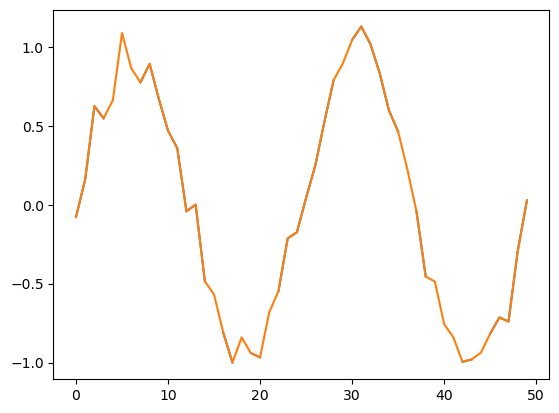

In [4]:
plt.plot(results['imputation_results']["original_series"])
plt.plot(results['imputation_results']["reconstructed_series"])